## biGRU RNN

### Data Preprocessing
Loads the IMDB dataset using TensorFlow's Keras module, creating training and testing sets. It further maps numeric sequences to human-readable text.

In [35]:
m = 1000   # Number of words in the vocabulary
n = 20     # N most frequent words to skip
k = 0      # K least frequent words to skip

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)
word_index = tf.keras.datasets.imdb.get_word_index()

index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'

x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

### Vectorizing our text

In order to create word embeddings, we need to map each word of our vocabulary into an integer. This can be done with several approaches using Keras. We are going to use the `TextVectorization` layer.

*   We need a vocabulary size

*   We need a number which will be used as the length of the sequence that will be passed into the network. A simple heuristic: average length of the training documents


In [37]:
train_doc_length = 0
for doc in x_train:
  tokens = str(doc).split()
  train_doc_length += len(tokens)

print('\nTraining data average document length =', (train_doc_length / len(x_train)))


Training data average document length = 238.71364


In [38]:
VOCAB_SIZE = 100000
SEQ_MAX_LENGTH = 240
vectorizer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, 
                                               output_mode='int', 
                                               ngrams=1, name='vector_text',
                                               output_sequence_length=SEQ_MAX_LENGTH)

with tf.device('/CPU:0'):
  vectorizer.adapt(x_train)

### Visualization

In [45]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pandas import DataFrame
from sklearn.metrics import (accuracy_score, auc, confusion_matrix, f1_score,
                             precision_score, recall_score, roc_curve)


def evaluate_estimator(estimator, x_train, y_train, x_test, y_test, splits=5):
    train_accuracies, test_accuracies, train_precisions, test_precisions = [], [], [], []
    train_recall, test_recall, train_f1, test_f1 = [], [], [], []
    split_size = len(x_train) // splits

    for i in range(1, splits + 1):
        x_train_split, y_train_split = x_train[:i * split_size], y_train[:i * split_size]
        estimator.fit(x_train_split, y_train_split)

        train_pred, test_pred = estimator.predict(x_train_split), estimator.predict(x_test)

        train_accuracies.append(accuracy_score(y_train_split, train_pred))
        test_accuracies.append(accuracy_score(y_test, test_pred))

        train_precisions.append(precision_score(y_train_split, train_pred))
        test_precisions.append(precision_score(y_test, test_pred))

        train_recall.append(recall_score(y_train_split, train_pred))
        test_recall.append(recall_score(y_test, test_pred))

        train_f1.append(f1_score(y_train_split, train_pred))
        test_f1.append(f1_score(y_test, test_pred))

    cm = confusion_matrix(y_test, test_pred)

    return {'estimator': estimator.__class__.__name__,
            'split_size': split_size,
            'splits': splits,
            'test_pred': test_pred,
            'train_accuracy': train_accuracies,
            'test_accuracy': test_accuracies,
            'train_precision': train_precisions,
            'test_precision': test_precisions,
            'train_recall': train_recall,
            'test_recall': test_recall,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'confusion_matrix': cm}         

def evaluate_rnn(estimator, x_train, y_train, x_test, y_test, epochs=1, num_layers=1, emb_size=64, h_size=64, batch_size=64, validation_split=0.1, splits=5):
    train_accuracies, test_accuracies, train_precisions, test_precisions = [], [], [], []
    train_recall, test_recall, train_f1, test_f1 = [], [], [], []
    
    split_size = len(x_train) // splits
    
    for i in range(splits):
        x_train_split = x_train[:split_size * (i + 1)]
        y_train_split = y_train[:split_size * (i + 1)]
        
        new_estimator = estimator(num_layers=num_layers, emb_size=emb_size, h_size=h_size)
        model = new_estimator.get_model()
        
        model.fit(x_train_split, y_train_split, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
        
        train_pred = (model.predict(x_train_split) > 0.5).astype("int32")
        test_pred = (model.predict(x_test) > 0.5).astype("int32")
        
        train_accuracies.append(accuracy_score(y_train_split, train_pred))
        test_accuracies.append(accuracy_score(y_test, test_pred))

        train_precisions.append(precision_score(y_train_split, train_pred, zero_division=0))
        test_precisions.append(precision_score(y_test, test_pred, zero_division=0))

        train_recall.append(recall_score(y_train_split, train_pred))
        test_recall.append(recall_score(y_test, test_pred))

        train_f1.append(f1_score(y_train_split, train_pred))
        test_f1.append(f1_score(y_test, test_pred))
    
    cm = confusion_matrix(y_test, test_pred)

    return {
        'estimator': estimator.__name__,
        'split_size': split_size,
        'splits': splits,
        'test_pred': test_pred.flatten(),
        'train_accuracy': train_accuracies,
        'test_accuracy': test_accuracies,
        'train_precision': train_precisions,
        'test_precision': test_precisions,
        'train_recall': train_recall,
        'test_recall': test_recall,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'confusion_matrix': cm
    }

def plot_confusion_matrix(cm, title):
    """
    Creates a heatmap of the confusion matrix.

    Arguments:
      cm: The confusion matrix to be plotted.
      title: The title of the plot.
    Returns:
      A heatmap of the confusion matrix.
    """
    
    cm_matrix = DataFrame(data=cm, columns=['Predicted Negative', 'Predicted Positive'],
                          index=['Actual Negative', 'Actual Positive'])
    
    plt.figure(figsize=(8, 6))
    ax = plt.axes()
    ax.set_title(f'Confusion Matrix Heatmap for {title}')
    
    return sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

def plot_metrics_table(evaluate_metrics):
    """
    Creates and displays a table of the train/test accuracies, precisions, recalls,
    and F1 scores for each split. 

    Arguments:
      evaluate_metrics: The dictionary containing the train/test data metrics.
    """
    num_splits = evaluate_metrics['splits']
    split_size = evaluate_metrics['split_size']

    df = DataFrame({
        f'{metric} {data_type}': np.round(evaluate_metrics[f'{data_type.lower()}_{metric.lower()}'], 2)
        for metric in ['Accuracy', 'Precision', 'Recall', 'F1']
        for data_type in ['Train', 'Test']
    }, index=list(range(split_size, split_size * (num_splits + 1), split_size)))

    display(df)

def plot_learning_curves(classification_data):
  """
  Visualize both normal and zoomed learning curves of accuracy, precision, recall, and F1 for training and testing sets.

  Arguments:
    classification_data: The dictionary containing the train/test data.
  """
  num_splits = classification_data['splits']
  split_size = classification_data['split_size']

  x_values = list(range(split_size, split_size * (num_splits + 1), split_size))

  metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

  for metric in metrics:
      # Create a new figure for each metric
      plt.figure(figsize=(7, 4))

      # Plot normal learning curves
      plt.subplot(1, 2, 1)
      plt.plot(x_values, classification_data[f'train_{metric.lower()}'], label='Train')
      plt.plot(x_values, classification_data[f'test_{metric.lower()}'], label='Test')
      plt.title(f'{metric}')
      plt.xticks(x_values)
      plt.ylim(0.0 - 0.1, 1.0 + 0.1)
      plt.legend()

      # Plot zoomed learning curves
      plt.subplot(1, 2, 2)
      plt.plot(x_values, classification_data[f'train_{metric.lower()}'], label='Train')
      plt.plot(x_values, classification_data[f'test_{metric.lower()}'], label='Test')
      plt.title(f'{metric} (Zoomed In)')
      plt.xticks(x_values)

      # Calculate y-axis limits based on the range of y-values for each metric
      y_min = min(min(classification_data[f'train_{metric.lower()}']), min(classification_data[f'test_{metric.lower()}']))
      y_max = max(max(classification_data[f'train_{metric.lower()}']), max(classification_data[f'test_{metric.lower()}']))
      y_range = y_max - y_min
      plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

      plt.suptitle(f"Learning Curve for {classification_data['estimator']} - {metric}", fontsize=16)
      plt.gcf().supxlabel('Training Examples', ha='center', fontsize=10)
      plt.tight_layout(rect=[0, 0, 1, 0.98])
      plt.show()

def plot_metrics_table_differences(classifier1_data, classifier2_data):
    """
    Creates and displays a table of the differences in train/test accuracies, precisions, recalls,
    and F1 scores between two classifiers for each split.

    Arguments:
      classifier1_data: Dictionary containing train/test data for classifier 1.
      classifier2_data: Dictionary containing train/test data for classifier 2.
    """
    num_splits = classifier1_data['splits']
    split_size = classifier1_data['split_size']

    df = DataFrame({
        f'{metric} {data_type}': np.round(classifier1_data[f'{data_type.lower()}_{metric.lower()}'], 2) - np.round(classifier2_data[f'{data_type.lower()}_{metric.lower()}'], 2)
        for metric in ['Accuracy', 'Precision', 'Recall', 'F1']
        for data_type in ['Train', 'Test']
    }, index=list(range(split_size, split_size * (num_splits + 1), split_size)))

    display(df)

def plot_learning_curve_differences(classifier1_data, classifier2_data):
    """
    Visualize the differences between two classifiers and their learning curves for accuracy, precision, recall, and F1.

    Arguments:
      classifier1_data: Dictionary containing train/test data for classifier 1.
      classifier2_data: Dictionary containing train/test data for classifier 2.
    """

    num_splits = classifier1_data['splits']
    split_size = classifier1_data['split_size']
    x_values = list(range(split_size, split_size * (num_splits + 1), split_size))

    for metric in ['Accuracy', 'Precision', 'Recall', 'F1']:
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.plot(x_values, classifier1_data[f'train_{metric.lower()}'], label=f"{classifier1_data['estimator']} (Train)")
        plt.plot(x_values, classifier1_data[f'test_{metric.lower()}'], label=f"{classifier1_data['estimator']} (Test)")
        plt.plot(x_values, classifier2_data[f'train_{metric.lower()}'], label=f"{classifier2_data['estimator']} (Train)")
        plt.plot(x_values, classifier2_data[f'test_{metric.lower()}'], label=f"{classifier2_data['estimator']} (Test)")
        plt.title(metric)
        plt.ylim(0.0 - 0.1, 1.0 + 0.1)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(x_values, classifier1_data[f'train_{metric.lower()}'], label=f"{classifier1_data['estimator']} (Train)")
        plt.plot(x_values, classifier1_data[f'test_{metric.lower()}'], label=f"{classifier1_data['estimator']} (Test)")
        plt.plot(x_values, classifier2_data[f'train_{metric.lower()}'], label=f"{classifier2_data['estimator']} (Train)")
        plt.plot(x_values, classifier2_data[f'test_{metric.lower()}'], label=f"{classifier2_data['estimator']} (Test)")
        plt.title(f'{metric} (Zoomed In)')

        y_min_cl1 = min(min(classifier1_data[f'train_{metric.lower()}']), min(classifier1_data[f'test_{metric.lower()}']))
        y_max_cl1 = max(max(classifier1_data[f'train_{metric.lower()}']), max(classifier1_data[f'test_{metric.lower()}']))
        y_min_cl2 = min(min(classifier2_data[f'train_{metric.lower()}']), min(classifier2_data[f'test_{metric.lower()}']))
        y_max_cl2 = max(max(classifier2_data[f'train_{metric.lower()}']), max(classifier2_data[f'test_{metric.lower()}']))
        y_min = min(y_min_cl1, y_min_cl2)
        y_max = max(y_max_cl1, y_max_cl2)
        y_range = y_max - y_min
        plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

        plt.suptitle(f"{metric} Differences {classifier1_data['estimator']} - {classifier2_data['estimator']} (scikit)", fontsize=16)
        plt.gcf().supxlabel('Training Examples', ha='center', fontsize=10)
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

def smooth_curve(points, factor=0.8):
    """Smooth curve with exponential moving average"""
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def plot_loss(history, smooth=False):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_loss) + 1)

    if smooth:
        train_loss = smooth_curve(train_loss)
        val_loss = smooth_curve(val_loss)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')

    min_val_loss_epoch = val_loss.index(min(val_loss)) + 1
    plt.scatter(min_val_loss_epoch, min(val_loss), color='green', marker='o', label='Minimum Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_roc_curve(y_pred_cont, name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_cont)
    roc_auc = auc(fpr, tpr)

    figure, axis = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
    axis.plot(fpr, tpr, color='#2c8dc9', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    axis.plot([0, 1], [0, 1], color='#FFAD00', lw=2, linestyle='--', label='No Skill')
    axis.set_xlim([0.0, 1.0])
    axis.set_ylim([0.0, 1.05])
    axis.set_xlabel('False Positive Rate')
    axis.set_ylabel('True Positive Rate')
    axis.set_title(f'Receiver Operating Characteristic for {name}')
    axis.legend(loc="lower right")
    axis.grid(alpha=0.3)


### biGRU-RNN Implementation

In [40]:
class bigru_rnn():
    
    def __init__(self, num_layers=1, emb_size=64, h_size=64):
        self.num_layers = num_layers
        self.emb_size = emb_size
        self.h_size = h_size
        
        inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='txt_input')
        x = vectorizer(inputs)
        x = tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()),
                                        output_dim=self.emb_size, name='word_embeddings',
                                        mask_zero=True)(x)
        
        for n in range(self.num_layers):
            if n != self.num_layers - 1:
                x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=self.h_size, 
                                    name=f'bigru_cell_{n}', 
                                    return_sequences=True, 
                                    dropout=0.2))(x)
            else:
                x, forward_h, backward_h = tf.keras.layers.Bidirectional(
                                tf.keras.layers.GRU(units=self.h_size, name=f'bigru_cell{n}',
                                dropout=0.2, return_state=True))(x) # return_sequences is False by default
                
                x = tf.keras.layers.Concatenate()([forward_h, backward_h])

        x = tf.keras.layers.Dropout(rate=0.5)(x)
         
        o = tf.keras.layers.Dense(units=1, activation='sigmoid', name='lr')(x)
        
        self.model = tf.keras.models.Model(inputs=inputs, outputs=o, name='biGRU_RNN')
        self.model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy())

    def __name__(self):
        return 'biGRU RNN'
    
    def fit(self, x_train, y_train, epochs=1, batch_size=64, validation_split=0):
        self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    
    def get_model(self):
        return self.model
      

In [41]:
rnn = bigru_rnn(num_layers=1, emb_size=64, h_size=64)
model = rnn.get_model()
print(model.summary())

Model: "biGRU_RNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 txt_input (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 vector_text (TextVectoriza  (None, 240)                  0         ['txt_input[0][0]']           
 tion)                                                                                            
                                                                                                  
 word_embeddings (Embedding  (None, 240, 64)              62720     ['vector_text[0][0]']         
 )                                                                                                
                                                                                          

In [42]:
rnn_history = model.fit(x_train, y_train, epochs=6, batch_size=64, validation_split=0.2)
rnn_preds = model.predict(x_test)

Epoch 1/6
313/313 [==============================] - 79s 217ms/step - loss: 0.5898 - val_loss: 0.3982
Epoch 2/6
313/313 [==============================] - 70s 223ms/step - loss: 0.3950 - val_loss: 0.3722
Epoch 3/6
313/313 [==============================] - 76s 243ms/step - loss: 0.3443 - val_loss: 0.3564
Epoch 4/6
313/313 [==============================] - 72s 231ms/step - loss: 0.3308 - val_loss: 0.3761
Epoch 5/6
313/313 [==============================] - 72s 231ms/step - loss: 0.3217 - val_loss: 0.3571
Epoch 6/6
782/782 [==============================] - 45s 54ms/step


### biGRU Evaluation Results

#### Loss over epochs and ROC Curve

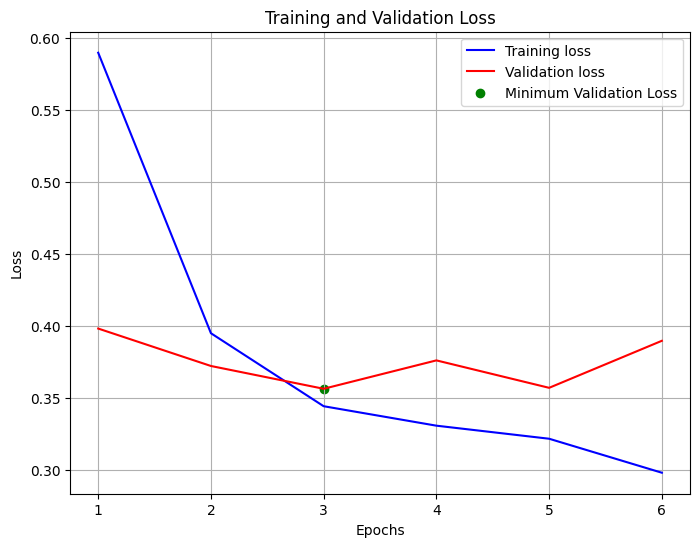

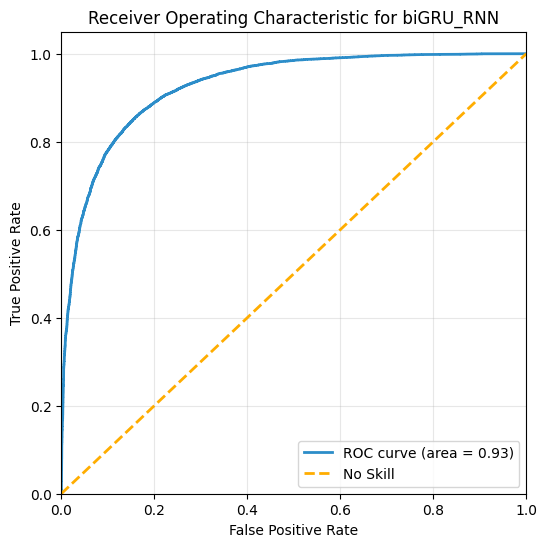

In [46]:
plot_loss(rnn_history)
plot_roc_curve(rnn_preds, model.name)

In [47]:
rnn_data = evaluate_rnn(bigru_rnn, x_train, y_train, x_test, y_test, num_layers=1, epochs=6, batch_size=64, splits=5)
rnn_data['estimator'] = 'biGRU RNN'

Epoch 1/6
71/71 [==============================] - 61s 400ms/step - loss: 0.6920 - val_loss: 0.6881
Epoch 2/6
71/71 [==============================] - 27s 379ms/step - loss: 0.6559 - val_loss: 0.5909
Epoch 3/6
71/71 [==============================] - 33s 470ms/step - loss: 0.5205 - val_loss: 0.5386
Epoch 4/6
71/71 [==============================] - 32s 446ms/step - loss: 0.4097 - val_loss: 0.5089
Epoch 5/6
71/71 [==============================] - 32s 454ms/step - loss: 0.3408 - val_loss: 0.4371
Epoch 6/6
782/782 [==============================] - 62s 79ms/step
Epoch 1/6
141/141 [==============================] - 78s 465ms/step - loss: 0.6838 - val_loss: 0.6454
Epoch 2/6
141/141 [==============================] - 63s 450ms/step - loss: 0.5181 - val_loss: 0.4096
Epoch 3/6
141/141 [==============================] - 63s 445ms/step - loss: 0.4008 - val_loss: 0.3643
Epoch 4/6
141/141 [==============================] - 63s 446ms/step - loss: 0.3386 - val_loss: 0.3684
Epoch 5/6
141/141 [======

,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.89,0.80,0.90,0.80,0.89,0.80,0.89,0.80
10000,0.89,0.83,0.88,0.83,0.90,0.85,0.89,0.84
15000,0.89,0.84,0.91,0.85,0.87,0.81,0.89,0.83
20000,0.89,0.84,0.91,0.87,0.86,0.81,0.88,0.84
25000,0.88,0.85,0.90,0.86,0.87,0.83,0.88,0.85


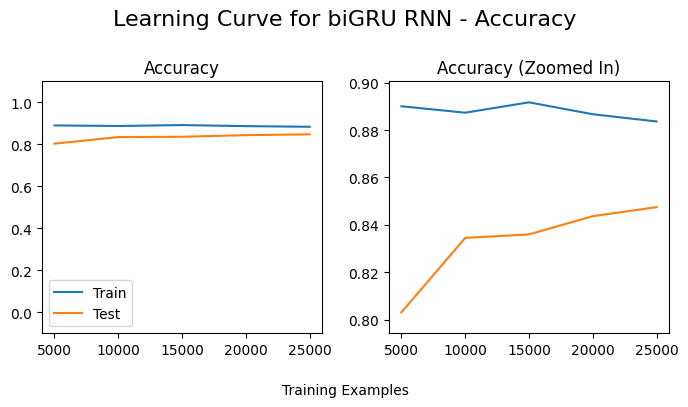

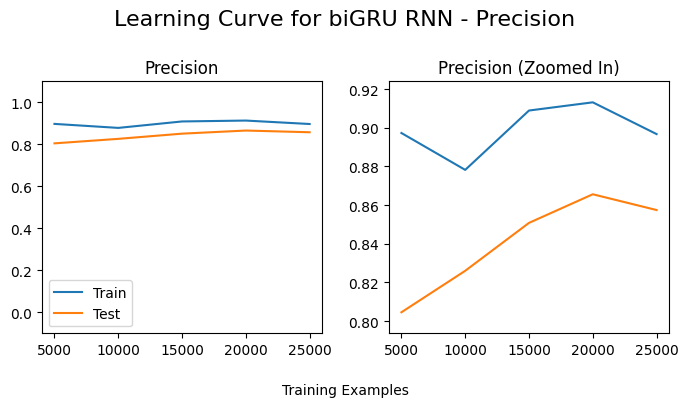

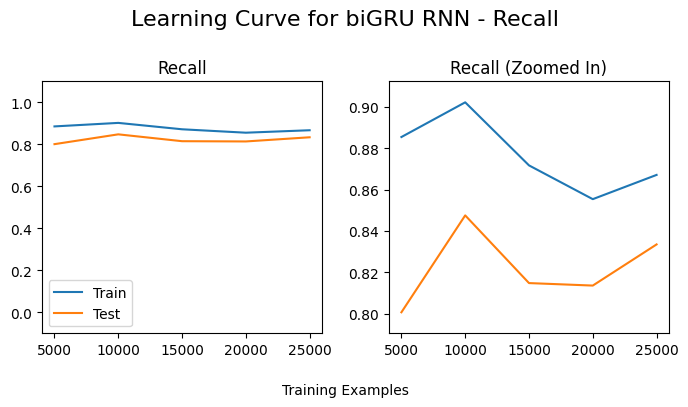

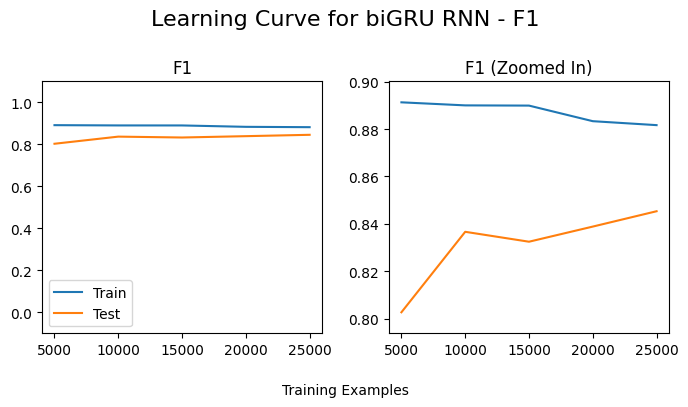

In [48]:
plot_metrics_table(rnn_data)
plot_learning_curves(rnn_data)

### Binary Vector Creation
Transforms the textual movie reviews into binary bag-of-words representations, indicating the presence (1) or absence (0) of words using scikit-learn's CountVectorizer.

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

binary_vectorizer = CountVectorizer(binary=True)
x_train_binary = binary_vectorizer.fit_transform(x_train)
x_test_binary = binary_vectorizer.transform(x_test)

x_train_binary = x_train_binary.toarray()
x_test_binary = x_test_binary.toarray()

### RNN against our Bernoulli Naive Bayes Implementation

#### Bernoulli Naive Bayes Implementation

In [50]:
class BernoulliNaiveBayes():
    def __init__(self):
        pass

    def fit(self, X, y):
        """
        Trains the Bernoulli Naive Bayes model by calculating prior and conditional log probabilities.

        Parameters:
        - X: Input feature matrix (binary values indicating feature presence/absence).
        - y: Binary class labels (1 for positive, 0 for negative).

        Returns:
        None
        """
        # Calculate the prior probability of each class (P(C=1) : positive and P(C=0) : negative)
        self.prob_pos = np.log((np.sum(y) + 1)/ (len(y) + 2))
        self.prob_neg = np.log(1 - (np.sum(y) + 1) / (len(y) + 2))

        # Calculate the probability of each feature for the given class
        # P(Xi=1|C=1) : probability of feature 1 given class 1
        self.prob_feature1_pos = np.log((np.sum(X[y == 1], axis = 0) + 1) / (np.sum(y) + 2))

        # P(Xi=0|C=1) : probability of feature 0 given class 1
        self.prob_feature0_pos = np.log(1.0 - (np.sum(X[y == 1], axis = 0) + 1) / (np.sum(y) + 2))
        
        # P(Xi=1|C=0) : probability of feature 1 given class 0
        self.prob_feature1_neg = np.log((np.sum(X[y == 0], axis = 0) + 1) / (len(y) - np.sum(y) + 2))

        # P(Xi=0|C=0) : probability of feature 0 given class 0
        self.prob_feature0_neg = np.log(1.0 - (np.sum(X[y == 0], axis = 0) + 1) / (len(y) - np.sum(y) + 2))

        return

    def predict(self, X):
        """
        Predicts the class labels based on input features.

        Parameters:
        - X: Input feature matrix (binary values indicating feature presence/absence).

        Returns:
        - pred: Predicted class labels (0 for negative, 1 for positive).
        """
        # Calculate the probability of each class for the given features
        tot_prob_pos = self.prob_pos + np.sum(self.prob_feature1_pos * X + self.prob_feature0_pos * (1 - X), axis=1)
        tot_prob_neg = self.prob_neg + np.sum(self.prob_feature1_neg * X + self.prob_feature0_neg * (1 - X), axis=1)

        # Predict the class with the higher probability
        pred = (tot_prob_pos > tot_prob_neg).astype(int)

        return pred

#### Comparison

,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.06,-0.02,0.08,-0.01,0.04,-0.04,0.05,-0.03
10000,0.07,0.01,0.07,0.03,0.04,0.01,0.06,0.02
15000,0.07,0.02,0.10,0.05,0.02,-0.03,0.06,0.01
20000,0.07,0.02,0.10,0.06,0.01,-0.03,0.05,0.01
25000,0.06,0.04,0.10,0.06,0.02,-0.01,0.06,0.03


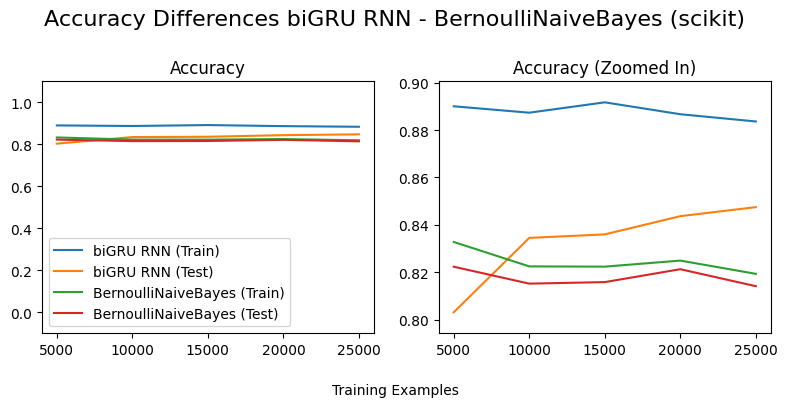

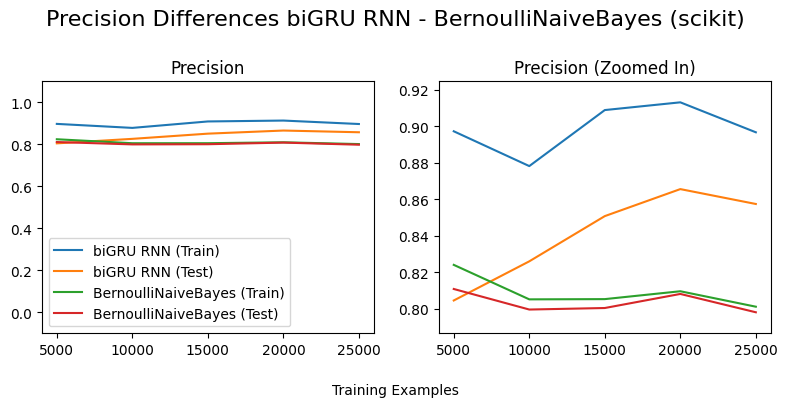

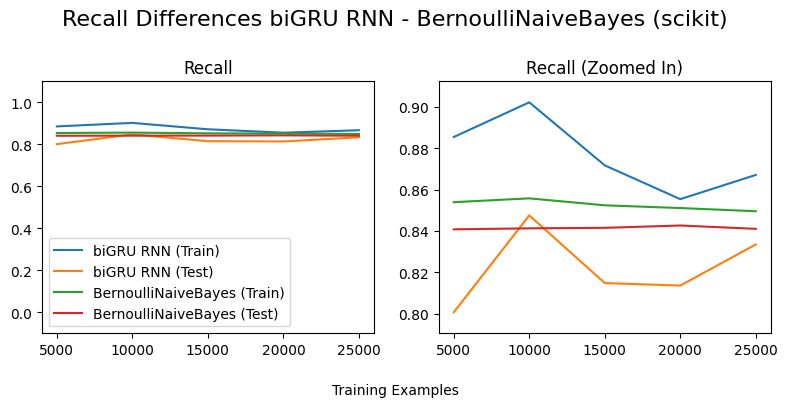

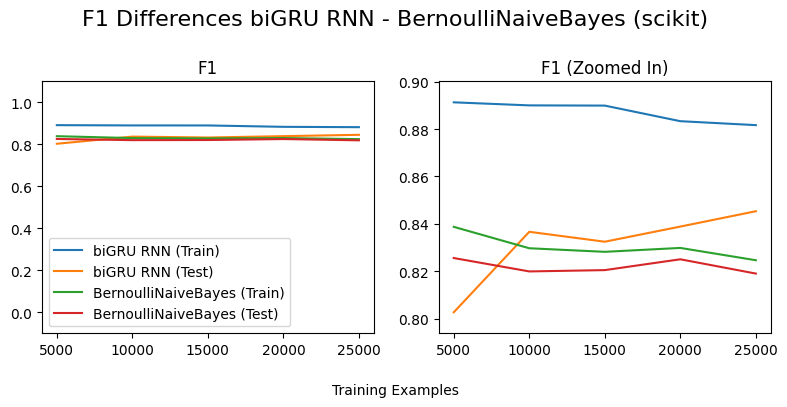

In [51]:
# Train our Bernoulli Naive Bayes model on the training data
bnb_data = evaluate_estimator(BernoulliNaiveBayes(), x_train_binary, y_train, x_test_binary, y_test, 5)

# Compare metrics and plot differences
plot_metrics_table_differences(rnn_data, bnb_data)
plot_learning_curve_differences(rnn_data, bnb_data)

### RNN against our Logistic Regression Implementation

#### Logistic Regression Implementation

In [52]:
import numpy as np
from sklearn.utils import shuffle

class LogisticRegressionSGD:
    def __init__(self, learning_rate=0.01, num_epochs=1000, lambda_value=0.001, threshold=0.5, tol=1e-4, patience=5):
        # Initialize logistic regression parameters
        self.learning_rate = learning_rate  # Learning rate for gradient descent
        self.num_epochs = num_epochs  # Maximum number of training epochs
        self.lambda_value = lambda_value  # Regularization parameter
        self.threshold = threshold  # Threshold for binary classification
        self.tol = tol  # Tolerance for early stopping
        self.patience = patience  # Patience for early stopping
        self.weights = None  # Model weights

    def sigmoid(self, x):
        # Sigmoid activation function
        return 1 / (1 + np.exp(-x))

    def initialize_parameters(self, n_features):
        # Initialize weights with zeros, including bias term
        self.weights = np.zeros(n_features + 1)

    def forward(self, X):
        # Forward pass to compute predicted probability
        linear_combination = np.dot(X, self.weights[1:]) + self.weights[0]
        return self.sigmoid(linear_combination)

    def compute_loss(self, y_true, y_pred):
        # Clip predicted probabilities to prevent numerical instability
        epsilon = 1e-15 
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        # Compute cross-entropy loss
        loss = -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / len(y_true)

        # Compute L2 regularization term
        regularization_term = 0.5 * self.lambda_value * np.sum(self.weights[1:]**2) # exclude bias term

        # Total loss is the sum of cross-entropy loss and regularization term
        return loss + regularization_term

    def stochastic_gradient_descent(self, X, y):
        # Iterate through each training example
        for i in range(len(y)):
            # Extract the i-th training example and reshape it to a 2D array
            xi = X[i, :].reshape(1, -1)
            yi = y[i]

            # Forward pass to compute predicted probability for the i-th example
            y_pred = self.forward(xi)

            # Compute gradient of the loss with respect to weights
            # Gradient is the dot product of input features and prediction error, 
            # plus the derivative of the regularization term
            dw = np.dot(xi.T, (y_pred - yi)) + 2 * self.lambda_value * self.weights[1:] 
            dw_bias = y_pred - yi

            # Update model weights using the gradient and learning rate
            self.weights[1:] -= self.learning_rate * dw
            # Update bias term separately
            self.weights[0] -= self.learning_rate * np.mean(dw_bias)

    def fit(self, X, y):
        # Initialize model weights
        self.initialize_parameters(X.shape[1])

        # Initialize variables for tracking convergence and early stopping
        min_loss = np.inf  # Initialize minimum loss to infinity
        no_improvement_count = 0  # Counter for consecutive epochs with no improvement

        # training loop over epochs until convergence or maximum number of epochs reached
        for epoch in range(self.num_epochs):
            # Shuffle training examples
            X, y = shuffle(X, y, random_state=0)

            # Perform stochastic gradient descent
            self.stochastic_gradient_descent(X, y)

            # Compute loss and check for convergence
            y_pred_train = self.forward(X)
            loss_train = self.compute_loss(y, y_pred_train)

            if loss_train > min_loss + self.tol:
                no_improvement_count += 1
            else:
                min_loss = loss_train
                no_improvement_count = 0

            if no_improvement_count == self.patience:
                print(f"Length of training examples : {len(X)} - Converged after {epoch + 1} epochs with training loss {min_loss}")
                break

    def predict(self, X):
        # Compute predicted probabilities
        probabilities = self.forward(X)

        # Predict class labels based on predicted probabilities
        y_pred = (probabilities > self.threshold).astype(int)

        return y_pred


#### Comparison

Length of training examples : 5000 - Converged after 18 epochs with training loss 0.28936117164218816
Length of training examples : 10000 - Converged after 14 epochs with training loss 0.319975171572952
Length of training examples : 15000 - Converged after 21 epochs with training loss 0.33449121229118106
Length of training examples : 20000 - Converged after 9 epochs with training loss 0.3419803542004889
Length of training examples : 25000 - Converged after 10 epochs with training loss 0.3447577951347203


,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.00,-0.03,-0.04,-0.07,0.05,0.04,0.00,-0.01
10000,0.01,-0.01,-0.02,-0.03,0.04,0.03,0.01,0.00
15000,0.02,-0.01,0.02,-0.02,0.03,0.00,0.02,-0.01
20000,0.03,-0.01,0.07,0.05,-0.04,-0.08,0.01,-0.01
25000,0.02,0.00,0.06,0.03,-0.03,-0.06,0.01,-0.01


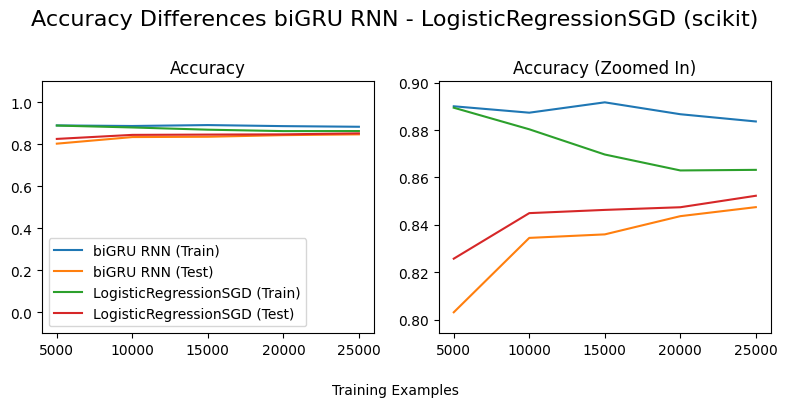

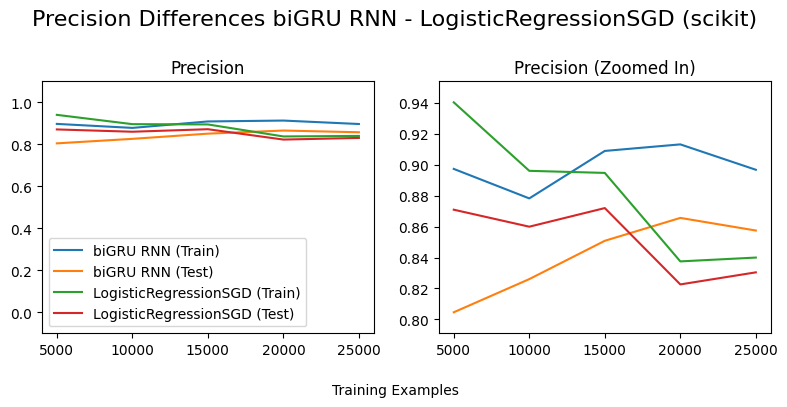

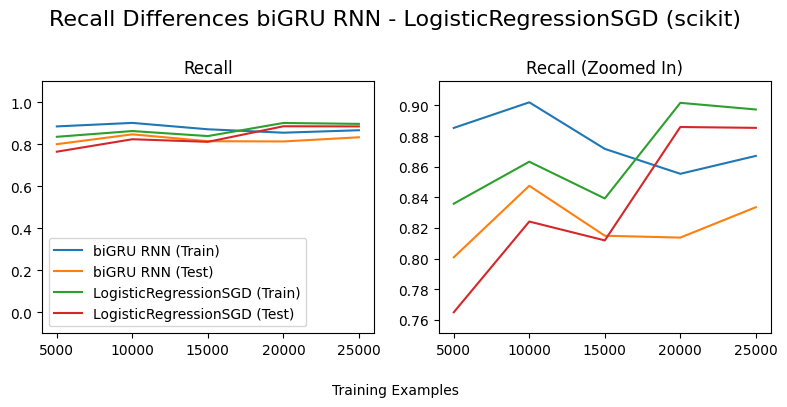

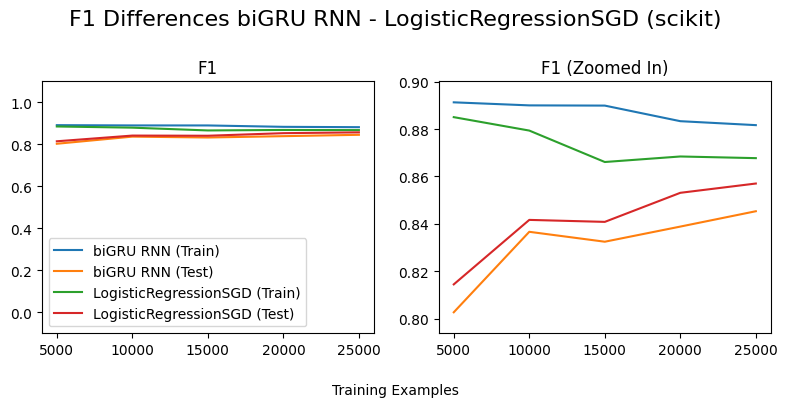

In [53]:
# Train our Logistic Regression model on the training data
logreg_data = evaluate_estimator(LogisticRegressionSGD(), x_train_binary, y_train, x_test_binary, y_test, 5)

# Compare metrics and plot differences
plot_metrics_table_differences(rnn_data, logreg_data)
plot_learning_curve_differences(rnn_data, logreg_data)

### RNN against our Random Forest Implementation

#### Random Forest Implementation

In [54]:
from concurrent.futures import ThreadPoolExecutor
from sklearn.tree import DecisionTreeClassifier
from collections import Counter

"""
Returns a bootstrapped sample of the data (with replacement).
"""
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idx = np.random.choice(n_samples, size=n_samples, replace=True)
    return X[idx], y[idx]
    
"""
Implementation of a Random Forest classifier
"""
class RandomForest:

    def __init__(self, n_trees=100, min_samples_split=2, min_samples_leaf=1, max_depth=20, max_features=10):
        self.n_trees = n_trees
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []
        self.n_features = None
        
    """
    Trains a tree using the ID3 algorithm and a bootstrapped sample of the data.
    """
    def train_tree(self, X, y):
        X_sample, y_sample = bootstrap_sample(X, y)
        tree = DecisionTreeClassifier(criterion='entropy', max_depth=self.max_depth, min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf, max_features=self.max_features)
        tree.fit(X_sample, y_sample)
        return tree
    
    """
    Fit the Random Forest model to the training data.
    """
    def fit(self, X, y):
        self.n_features = X.shape[1]  # Store the number of features
        with ThreadPoolExecutor() as executor:
            self.trees = list(executor.map(lambda _: self.train_tree(X, y), range(self.n_trees)))
    
    """
    Predict the class for each sample in X using majority voting.
    """
    def predict(self, X):
        with ThreadPoolExecutor() as executor:
            predictions = np.array(list(executor.map(lambda tree: tree.predict(X), self.trees)))
            majority_votes = np.apply_along_axis(self.break_ties, axis=0, arr=predictions)
        return majority_votes
        
    """
    Utility function to break ties in majority voting.
    """
    def break_ties(self, votes):
        vote_count = Counter(votes)
        top_two = vote_count.most_common(2)
        if len(top_two) > 1 and top_two[0][1] == top_two[1][1]:
            return np.random.choice([top_two[0][0], top_two[1][0]])
        return top_two[0][0]
    
    """
    Predict the class probabilities for each sample in X using majority voting. (To be used with roc_curve)
    """
    def predict_proba(self, X):
        predictions_proba = np.array([tree.predict_proba(X) for tree in self.trees])
        majority_votes_proba = np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions_proba)
        return majority_votes_proba
        
    """
    Returns the parameters of the classifier.
    """
    def get_params(self, deep=True):
        return {"n_trees": self.n_trees, "min_samples_split": self.min_samples_split, 
            "max_depth": self.max_depth, "max_features": self.max_features, "min_samples_leaf": self.min_samples_leaf}
    
    """
    Sets the parameters of the classifier.
    """
    def set_params(self, **parameters):
        # Set parameters for the model
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        # Return the updated instance
        return self

#### Comparison

,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,-0.05,0.01,0.00,0.06,-0.11,-0.09,-0.06,-0.01
10000,-0.03,0.04,0.01,0.09,-0.09,-0.04,-0.04,0.03
15000,-0.03,0.05,0.04,0.09,-0.11,-0.06,-0.03,0.02
20000,-0.02,0.04,0.04,0.11,-0.12,-0.07,-0.04,0.02
25000,-0.02,0.05,0.04,0.10,-0.10,-0.04,-0.03,0.04


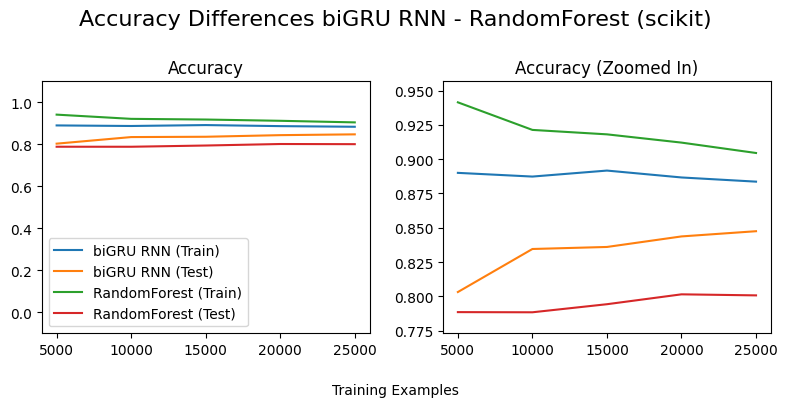

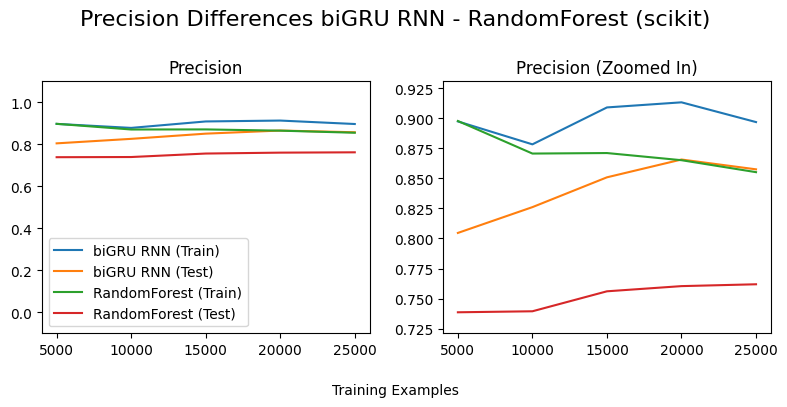

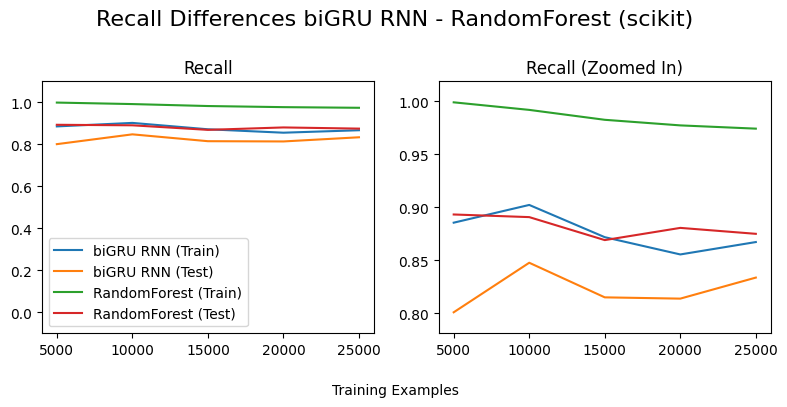

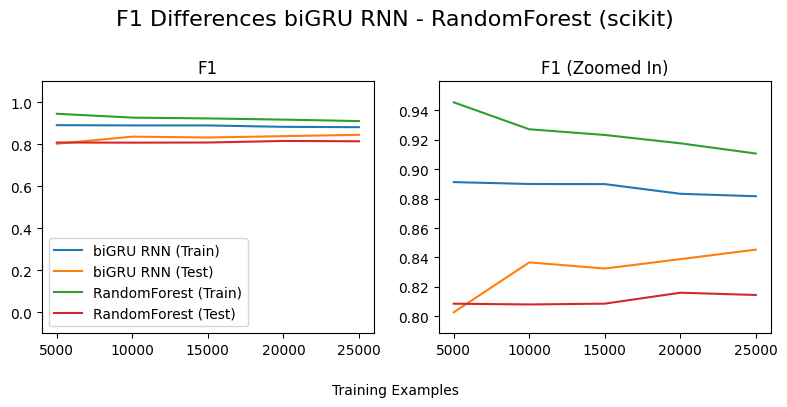

In [55]:
# Train our Random Forest model on the training data
rf_data = evaluate_estimator(RandomForest(), x_train_binary, y_train, x_test_binary, y_test, 5)

# Compare metrics and plot differences
plot_metrics_table_differences(rnn_data, rf_data)
plot_learning_curve_differences(rnn_data, rf_data)